## Loading training data

In [17]:
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras

In [19]:
data = pd.read_parquet("train-00000-of-00001-c08a401c53fe5312.parquet") 
data.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


## Data pre-processing

In [21]:
def bytes_to_image(d):
    if isinstance(d, dict) and "bytes" in d:
        bytes_ls = d["bytes"]
        np_ls = np.frombuffer(bytes_ls, np.uint8)
        image = cv2.imdecode(np_ls, cv2.IMREAD_GRAYSCALE)
        return image
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(d)}")

In [23]:
data["img_arr"] = data["image"].apply(bytes_to_image)
data.drop("image", axis = 1, inplace = True)
data.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [25]:
label_to_class_mapping = {0: "Mild_Demented", 1: "Moderate_Demented", 2: "Non_Demented",3: "Very_Mild_Demented"}
data["class"] = data["label"].map(label_to_class_mapping)
data.head()

,label,img_arr,class
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Non_Demented
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mild_Demented
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Very_Mild_Demented
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Very_Mild_Demented
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Non_Demented


## Model training

In [128]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

model = model_builder(weights = "imagenet")
model.layers[-1].activation = None

## Grad CAM

In [138]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [150]:
def save_and_display_gradcam(img_array, heatmap, alpha=0.4):
    img_display = img_array[0]
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    img_display = np.uint8(255 * img_display)

    heatmap = np.uint8(255 * heatmap)

    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_display.shape[1], img_display.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img_display
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    plt.figure(figsize=(5, 5))
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.title(f"Grad CAM Overlay for an image of the {label} class")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


C:\Users\Anjana\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_453']. Received: the structure of inputs=*
  warnings.warn(


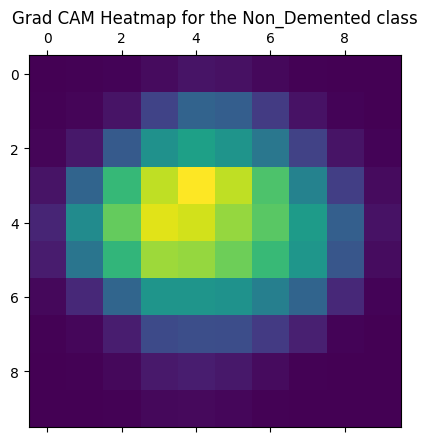

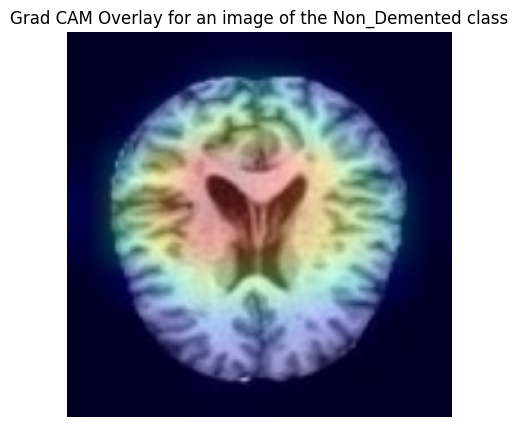

In [162]:
img_array = data.loc[0, "img_arr"]

if len(img_array.shape) == 2:
    img_array = np.stack((img_array,) * 3, axis = -1)

img_array = tf.image.resize(img_array, img_size).numpy()
img_array = np.expand_dims(img_array, axis = 0)
img_array = preprocess_input(img_array)

preds = model.predict(img_array)
label = data.loc[0, "class"]

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

plt.matshow(heatmap)
plt.title(f"Grad CAM Heatmap for the {label} class")
plt.show()

save_and_display_gradcam(img_array, heatmap)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


C:\Users\Anjana\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_453']. Received: the structure of inputs=*
  warnings.warn(


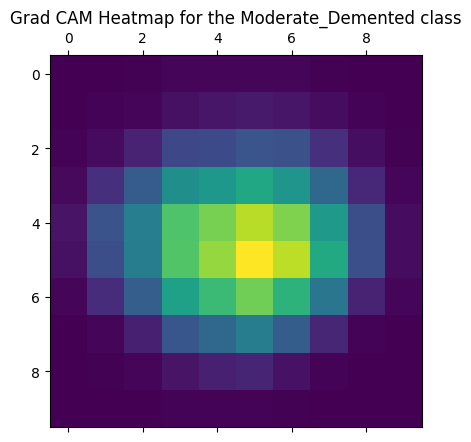

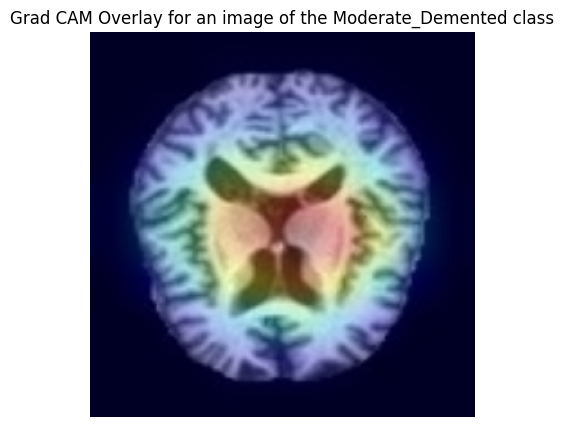

In [164]:
img_array = data.loc[11, "img_arr"]

if len(img_array.shape) == 2:
    img_array = np.stack((img_array,) * 3, axis = -1)

img_array = tf.image.resize(img_array, img_size).numpy()
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

preds = model.predict(img_array)
label = data.loc[11, "class"]

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

plt.matshow(heatmap)
plt.title(f"Grad CAM Heatmap for the {label} class")
plt.show()

save_and_display_gradcam(img_array, heatmap)